In [1]:
import pandas as pd
from datetime import datetime
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import lightgbm as lgb

In [4]:
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

In [5]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score

# Data Understanding, Cleaning and Pre-processing

In [7]:
# function to read inputs and merge
def data_read():
    iata = pd.read_csv('../data/iata_1_1.csv')
    events = pd.read_csv('../data/events_1_1.csv.gz')
    merged_data = events.merge(iata,left_on='origin',right_on='iata_code').drop('iata_code',axis=1)
    merged_data = merged_data.rename(columns={'lat':'origin_lat','lon':'origin_lon'})
    merged_data = merged_data.merge(iata,left_on='destination',right_on='iata_code').drop('iata_code',axis=1)
    merged_data = merged_data.rename(columns={'lat':'destination_lat','lon':'destination_lon'})
    return merged_data

In [8]:
#read input
booking_data = data_read()

In [9]:
booking_data.dtypes

ts                  object
event_type          object
user_id             object
date_from           object
date_to             object
origin              object
destination         object
num_adults           int64
num_children         int64
origin_lat         float64
origin_lon         float64
destination_lat    float64
destination_lon    float64
dtype: object

In [10]:
#check for NaN/NULL values
booking_data.isnull().sum()

ts                  0
event_type          0
user_id             0
date_from          84
date_to            12
origin              0
destination         0
num_adults          0
num_children        0
origin_lat          0
origin_lon          0
destination_lat     0
destination_lon     0
dtype: int64

In [11]:
#drop all NULL value records since it is not high in number
booking_data = booking_data.dropna()

In [12]:
#function to calculate the geo-distance between 2 lat-lon co-ordinates
def haversine_vectorize(lon1, lat1, lon2, lat2):

    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    newlon = lon2 - lon1
    newlat = lat2 - lat1

    haver_formula = np.sin(newlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(newlon/2.0)**2

    dist = 2 * np.arcsin(np.sqrt(haver_formula ))
    km = 6367 * dist #6367 for distance in KM for miles use 3958
    return km

In [13]:
#calculate geo_distance and assign as a new column
booking_data['geo_distance(km)'] = haversine_vectorize(booking_data['origin_lon'],booking_data['origin_lat'],booking_data['destination_lon'],booking_data['destination_lat'])

In [14]:
booking_data['origin'].value_counts().count()

236

In [15]:
# This method is responsible to calculate the number of days between 2 dates.
def no_of_days(date_from,looking_on):
    date_format = "%Y-%m-%d"
    a = datetime.strptime(looking_on, date_format)
    b = datetime.strptime(date_from, date_format)
    delta = b - a #days
    return delta.days

In [16]:
# This feature 'days_before_plan' will be used to calculate the no of days before the user is planning to book/search for a flight.
booking_data['look_on']=booking_data['ts'].str.split(" ", n = 1, expand = True)[0]        
booking_data['days_before_plan'] = booking_data.apply(lambda row : no_of_days(row['date_from'], row['look_on']), axis = 1)

In [17]:
# This feature 'trip_duration' represents for how many days the trip was planned for
booking_data['trip_duration'] = booking_data.apply(lambda row : no_of_days(row['date_to'], row['date_from']), axis = 1)

In [18]:
booking_data.head()

,ts,event_type,user_id,date_from,date_to,origin,destination,num_adults,num_children,origin_lat,origin_lon,destination_lat,destination_lon,geo_distance(km),look_on,days_before_plan,trip_duration
0,2017-04-27 11:06:51,search,60225f,2017-06-01,2017-06-07,PAR,NYC,6,1,48.85,2.35,40.71,-74.01,5834.154716,2017-04-27,35,6
1,2017-04-29 21:24:06,search,b32ef3,2017-05-02,2017-05-08,PAR,NYC,1,0,48.85,2.35,40.71,-74.01,5834.154716,2017-04-29,3,6
2,2017-04-27 21:14:19,search,565d54,2017-06-01,2017-06-18,PAR,NYC,3,1,48.85,2.35,40.71,-74.01,5834.154716,2017-04-27,35,17
3,2017-04-21 11:50:02,search,6d7b79,2017-08-23,2017-09-13,PAR,NYC,2,2,48.85,2.35,40.71,-74.01,5834.154716,2017-04-21,124,21
4,2017-04-21 18:05:01,search,60225f,2017-06-01,2017-06-07,PAR,NYC,6,1,48.85,2.35,40.71,-74.01,5834.154716,2017-04-21,41,6


In [19]:
#Extract search/book activity month and hour, travel start date month as these features might give an indication of seasonality to the model
booking_data['activity_month'] = pd.to_datetime(booking_data['ts']).dt.month
booking_data['travel_start_month'] = pd.to_datetime(booking_data['date_from']).dt.month
booking_data['activity_hour'] = pd.to_datetime(booking_data['ts']).dt.hour

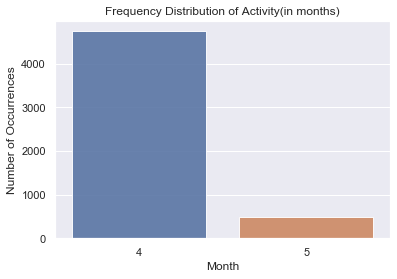

In [20]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
activity_book = booking_data.loc[booking_data['event_type'] == 'book','activity_month'].value_counts()
sns.set(style="darkgrid")
sns.barplot(activity_book.index, activity_book.values, alpha=0.9)
plt.title('Frequency Distribution of Activity(in months)')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Month', fontsize=12)
plt.show()

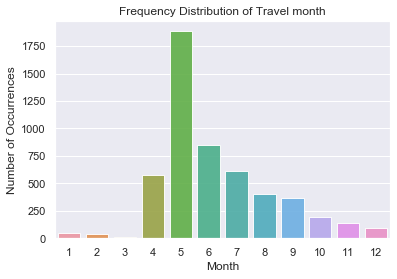

In [21]:
travel = booking_data.loc[booking_data['event_type'] == 'book','travel_start_month'].value_counts()
sns.set(style="darkgrid")
sns.barplot(travel.index, travel.values, alpha=0.9)
plt.title('Frequency Distribution of Travel month')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Month', fontsize=12)
plt.show()

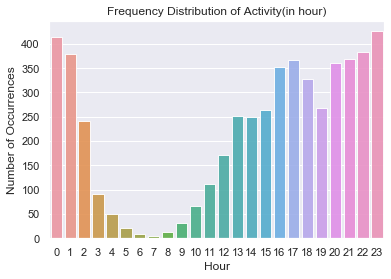

In [22]:
travel = booking_data.loc[booking_data['event_type'] == 'book','activity_hour'].value_counts()
sns.set(style="darkgrid")
sns.barplot(travel.index, travel.values, alpha=0.9)
plt.title('Frequency Distribution of Activity(in hour)')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Hour', fontsize=12)
plt.show()

In [23]:
# Encoding origin column
le = LabelEncoder()
le.fit(booking_data['origin'])
origin_name_mapping = dict(zip(le.transform(le.classes_), le.classes_))
booking_data['origin_enc'] = le.transform(booking_data['origin'])

#Encoding destination column
le = LabelEncoder()
le.fit(booking_data['destination'])
destination_name_mapping = dict(zip(le.transform(le.classes_), le.classes_))
booking_data['destination_enc'] = le.transform(booking_data['destination'])
        
# Encoding our label column i.e 'event_type'
le = LabelEncoder()
le.fit(booking_data['event_type'])
event_type_name_mapping = dict(zip(le.transform(le.classes_), le.classes_))
booking_data['event_type_enc'] = le.transform(booking_data['event_type'])

In [24]:
# Removing unwanted columns
booking_data.drop(['date_from','date_to','look_on','origin','destination','event_type','ts','user_id','origin_lat','origin_lon','destination_lat','destination_lon'],axis=1,inplace=True)

In [25]:
booking_data.head()

,num_adults,num_children,geo_distance(km),days_before_plan,trip_duration,activity_month,travel_start_month,activity_hour,origin_enc,destination_enc,event_type_enc
0,6,1,5834.154716,35,6,4,6,11,166,178,1
1,1,0,5834.154716,3,6,4,5,21,166,178,1
2,3,1,5834.154716,35,17,4,6,21,166,178,1
3,2,2,5834.154716,124,21,4,8,11,166,178,1
4,6,1,5834.154716,41,6,4,6,18,166,178,1


In [26]:
#remove records where 'days_before_plan' is negative as it is meaningless
booking_data = booking_data.loc[booking_data['days_before_plan'] > 0]

Text(0, 0.5, 'Frequency')

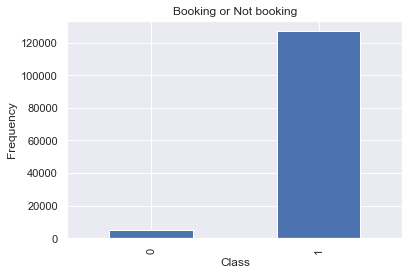

In [27]:
#check the distribution of search and book in event_type column
count_classes = pd.value_counts(booking_data['event_type_enc'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Booking or Not booking")
plt.xlabel("Class")
plt.ylabel("Frequency")

In [28]:
#split the dataset into independant and dependant features for model training and validation
X = booking_data.loc[:, booking_data.columns != 'event_type_enc']
y = booking_data.loc[:, booking_data.columns == 'event_type_enc']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [32]:
# Handling unbalanced dataset with SMOTE oversampling technique
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
sm = SMOTE(random_state=12)
x_train_sampled, y_train_sampled = sm.fit_sample(X_train, y_train)

# fit a lightGBM classifier model to the data
# Why LightGBM? - It works great with categorical features

# Hyper-parameter tuning using Grid Search Cross-validation

In [33]:
from sklearn.model_selection import GridSearchCV
lg = lgb.LGBMClassifier(silent=False)
param_dist = {"max_depth": [25,50, 75],
              "learning_rate" : [0.01,0.05,0.1],
              "num_leaves": [300,900,1200],
              "n_estimators": [200]
             }
grid_search = GridSearchCV(lg, n_jobs=-1, param_grid=param_dist, cv = 3, scoring="roc_auc", verbose=5)
grid_search.fit(x_train_sampled,y_train_sampled)
grid_search.best_estimator_

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  6.8min finished


[LightGBM] [Info] Number of positive: 88944, number of negative: 88944
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1193
[LightGBM] [Info] Number of data points in the train set: 177888, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier(max_depth=75, n_estimators=200, num_leaves=1200, silent=False)

# Model fit, prediction and evaluation

In [40]:
# categorical_feature = ['activity_month','origin_enc','destination_enc','travel_start_month','activity_hour']
model = lgb.LGBMClassifier(max_depth=75, n_estimators=200, num_leaves=1200, silent=False)
model.fit(x_train_sampled, y_train_sampled, eval_set=(X_test, y_test), feature_name='auto', categorical_feature = ['activity_month','origin_enc','destination_enc','travel_start_month','activity_hour'], verbose=50, early_stopping_rounds=100)
print(); print(model)
# make predictions
y_pred = model.predict(X_test)
# summarize the fit of the model
target_names = ['book', 'not_book']
print(); print(classification_report(y_test, y_pred,target_names=target_names))
print(); print(confusion_matrix(y_test, y_pred))

[LightGBM] [Info] Number of positive: 88944, number of negative: 88944
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002911 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1236
[LightGBM] [Info] Number of data points in the train set: 177888, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 100 rounds
[50]	valid_0's binary_logloss: 0.205708
[100]	valid_0's binary_logloss: 0.170347
[150]	valid_0's binary_logloss: 0.171671
[200]	valid_0's binary_logloss: 0.180676
Did not meet early stopping. Best iteration is:
[123]	valid_0's binary_logloss: 0.169242

LGBMClassifier(max_depth=75, n_estimators=200, num_leaves=1200, silent=False)

              precision    recall  f1-score   support

        book       0.31      0.51      0.38 

# Feature Importance

In [41]:
model.booster_.feature_importance()

# importance of each attribute
fea_imp_ = pd.DataFrame({'cols':x_train_sampled.columns, 'fea_imp':model.feature_importances_})
fea_imp_.loc[fea_imp_.fea_imp > 0].sort_values(by=['fea_imp'], ascending = False)

,cols,fea_imp
2,geo_distance(km),45233
3,days_before_plan,44997
4,trip_duration,25905
0,num_adults,9190
9,destination_enc,7057
7,activity_hour,6315
8,origin_enc,4443
1,num_children,1760
6,travel_start_month,1465
5,activity_month,1112
